# Neural Network Classification with PyTorch

Classification is a problem of predicting wether something is one thing or another

## 1. Make classificqtion data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
print(f"First 5 samples of X: \n{X[:5]}\n")
print(f"First 5 samples of y: \n{y[:5]}")

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 samples of y: 
[1 1 1 1 0]


In [3]:
# Make a DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[0, 1],
    "label": y
})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.231481,1
2,-0.815392,0.231481,1
3,-0.393731,0.231481,1
4,0.442208,0.231481,0


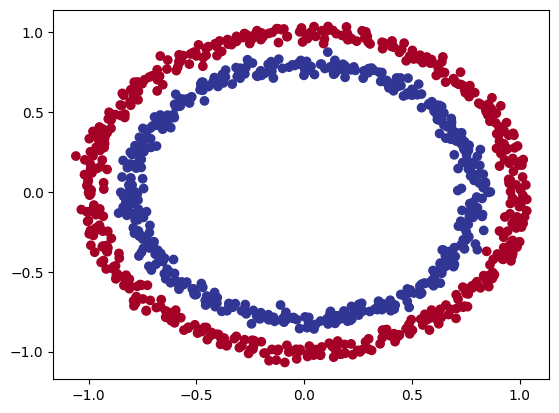

In [4]:
# Visualize

import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.show()

Note: The data we're working with is often referred to as a toy dataset, a dataset that is amll enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: \n{X_sample}\n")
print(f"Value for one sample of y: \n{y_sample}\n")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Values for one sample of X: 
[0.75424625 0.23148074]

Value for one sample of y: 
1

Shape of X: (1000, 2)
Shape of y: (1000,)


### 1.2 Turn data into tensors and create train and test splits

In [7]:
# Turn data into tensors
import torch
torch.__version__

'2.5.1+cu124'

In [8]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [9]:
X.shape, X[:5]

(torch.Size([1000, 2]),
 tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]))

In [10]:
y.shape, y[:5]

(torch.Size([1000]), tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test and 80% will be train
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [13]:
n_samples

1000

## 2. Building a model

Lets build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Cinstruct a model (by subclassin `nn.nodule`)
3. Define a loss funtion and optimizer
4. Create a training and test loop

In [14]:
# Import
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've device agnostic code, lets create a model that:

1. Subclass `nn.module` (almost all models in PyToch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send it to the target device.

In [15]:
# 1. Construct a model that subclass nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2.Create 2 nn.Linear layers capable of handling shapes of our data
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)

  # 3. Define a forward method that outlines the forward pass
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))

    # 4. Instantiate an instance of our model class and send it to the target device

In [16]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.4607,  0.7051],
        [-0.6031,  0.0755],
        [ 0.6851,  0.5419],
        [-0.2053, -0.5478],
        [ 0.4608, -0.3463]], requires_grad=True)

In [18]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5098, -0.3231],
                      [ 0.6438,  0.3617],
                      [ 0.0528, -0.1691],
                      [ 0.4258,  0.0937],
                      [ 0.5058, -0.2076]])),
             ('0.bias', tensor([ 0.4510, -0.1725, -0.4361,  0.3156,  0.1366])),
             ('1.weight',
              tensor([[-0.3122, -0.4189,  0.3289,  0.2076,  0.2114]])),
             ('1.bias', tensor([-0.3728]))])

In [20]:
# Make Predictions
model_0.eval()
with torch.inference_mode():
  untrained_preds = model_0(X_test)
untrained_preds.shape, untrained_preds[:5], y_test[:5]

(torch.Size([200, 1]),
 tensor([[-0.6180],
         [-0.6143],
         [-0.5211],
         [-0.6459],
         [-0.3520]]),
 tensor([1., 0., 1., 0., 1.]))

In [21]:
torch.round(untrained_preds[:5])

tensor([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-0.]])

### 2.1 Setup loss function and optimizer

Which loss function or optimizer to use
This is problem specific.

For example for regression you might want MAE or MSE

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how *wrong* the model's predictions are.

And for optimizers, two of the most common and useful are SGD and Adam. However PyTorch has many build in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`
* For a definition on what a logit is in deep learning: https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean

In [22]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built in

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3.Train Model

To train our model, we're going to need to build a training loop with the following steps
1. Forwards pass
2. Calculate the loss
3. Optimizer Zero Grad
4. Loss Backwards
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (eg, sigmoid for binary classification and softmax for multiclass classification)


Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [24]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test)
y_logits[:5]

tensor([[-0.6180],
        [-0.6143],
        [-0.5211],
        [-0.6459],
        [-0.3520]])

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
# Use sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.3502],
        [0.3511],
        [0.3726],
        [0.3439],
        [0.4129]])

For our prediction probability values, we need to perform a range-style rounding them:
* `y_pred_prob` >=0.5, `y=1` (class 1)
* `y_pred_prob` <0.5, `y=0` (class 0)

In [28]:
# Find the predicted label based on the prediction probabilities
y_preds =  torch.round(y_pred_probs)

# Full
# y_preds = torch.round(torch.sigmoid(model_0(X_test)))

In [29]:
accuracy_fn(y_test, y_preds.squeeze())

50.0

### 3.2 Building a training loop and testing loop

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate Loss / Accuracy:
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_train, y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # Optimizer Step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.72449, Acc: 50.00% | Test Loss: 0.72050, Test Acc: 50.00%
Epoch: 10 | Loss: 0.70587, Acc: 50.00% | Test Loss: 0.70294, Test Acc: 50.00%
Epoch: 20 | Loss: 0.69891, Acc: 50.00% | Test Loss: 0.69630, Test Acc: 50.00%
Epoch: 30 | Loss: 0.69622, Acc: 40.38% | Test Loss: 0.69377, Test Acc: 46.00%
Epoch: 40 | Loss: 0.69512, Acc: 46.38% | Test Loss: 0.69282, Test Acc: 47.50%
Epoch: 50 | Loss: 0.69460, Acc: 47.75% | Test Loss: 0.69248, Test Acc: 51.00%
Epoch: 60 | Loss: 0.69431, Acc: 48.50% | Test Loss: 0.69240, Test Acc: 50.50%
Epoch: 70 | Loss: 0.69412, Acc: 48.75% | Test Loss: 0.69241, Test Acc: 51.00%
Epoch: 80 | Loss: 0.69397, Acc: 48.75% | Test Loss: 0.69248, Test Acc: 50.50%
Epoch: 90 | Loss: 0.69385, Acc: 49.12% | Test Loss: 0.69256, Test Acc: 51.00%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual

To do so, we're going to import a function called `plot_decision_boundary()` from the file below.

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py


In [2]:
import requests
from pathlib import Path

# download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [47]:
from helper_functions import plot_decision_boundary, plot_predictions

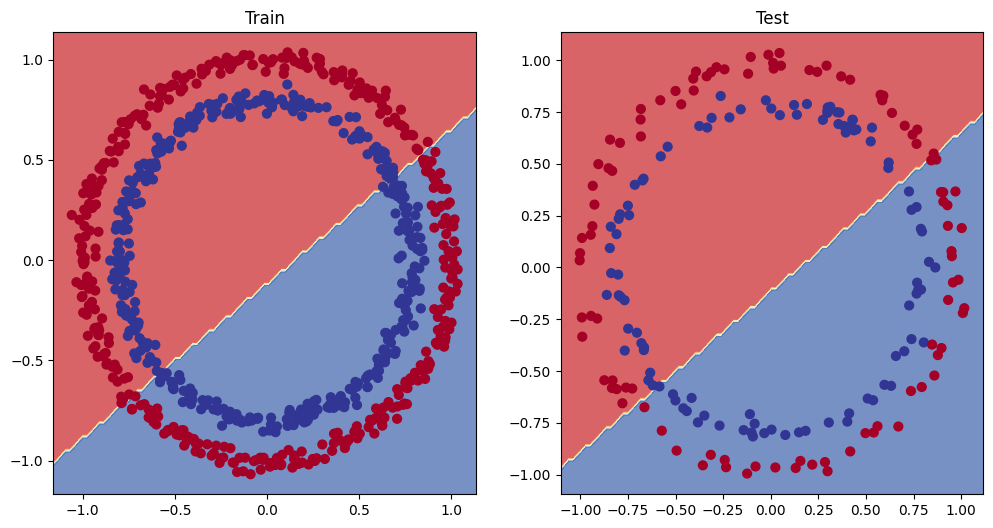

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.show()

## 5. Improving a model (from a model prespective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from our model's perspective because they deal with the model rather than the data.

And because these options are all values we can change, they are called **hyperparameters**

Let's try and improve our model by:
* adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs.

In [39]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=10)
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing leverages speed ups where possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 1000

# Build a training loop
for epoch in range(epochs):
  model_1.train()

  # Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer Zero Grad
  optimizer.zero_grad()

  # Loss Backwards
  loss.backward()

  # Optimizer Step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69322 | Train Acc: 49.88% | Test Loss: 0.69322 | Test Acc: 49.50%
Epoch: 100 | Train Loss: 0.69317 | Train Acc: 49.50% | Test Loss: 0.69335 | Test Acc: 53.00%
Epoch: 200 | Train Loss: 0.69313 | Train Acc: 49.38% | Test Loss: 0.69347 | Test Acc: 50.50%
Epoch: 300 | Train Loss: 0.69309 | Train Acc: 50.00% | Test Loss: 0.69358 | Test Acc: 51.00%
Epoch: 400 | Train Loss: 0.69307 | Train Acc: 50.62% | Test Loss: 0.69368 | Test Acc: 47.50%
Epoch: 500 | Train Loss: 0.69305 | Train Acc: 50.50% | Test Loss: 0.69378 | Test Acc: 49.00%
Epoch: 600 | Train Loss: 0.69303 | Train Acc: 50.88% | Test Loss: 0.69387 | Test Acc: 47.00%
Epoch: 700 | Train Loss: 0.69302 | Train Acc: 50.88% | Test Loss: 0.69394 | Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69301 | Train Acc: 50.50% | Test Loss: 0.69402 | Test Acc: 46.50%
Epoch: 900 | Train Loss: 0.69301 | Train Acc: 50.75% | Test Loss: 0.69408 | Test Acc: 47.50%


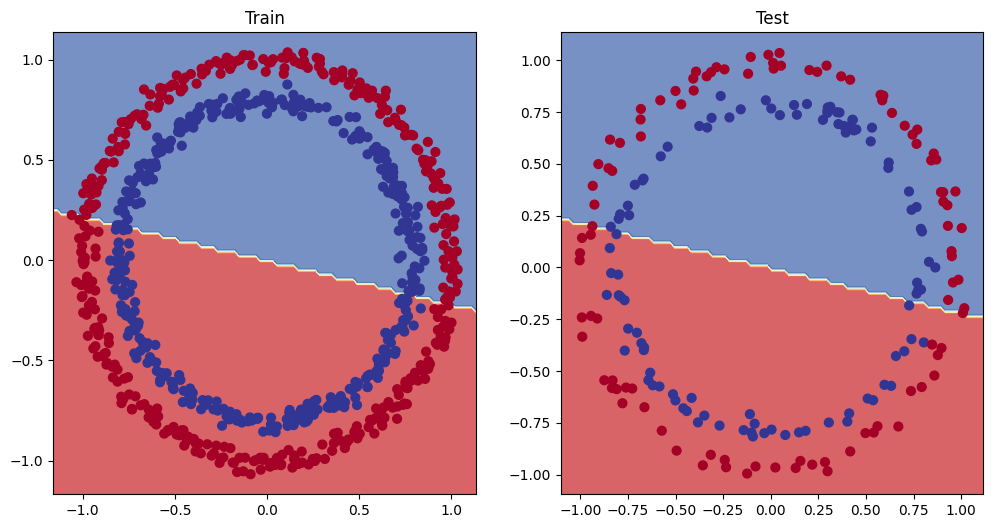

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
plt.show()

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is test out a smaller problem


In [45]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create Data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [46]:
# Create train and test split

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

# Check length of tensors
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

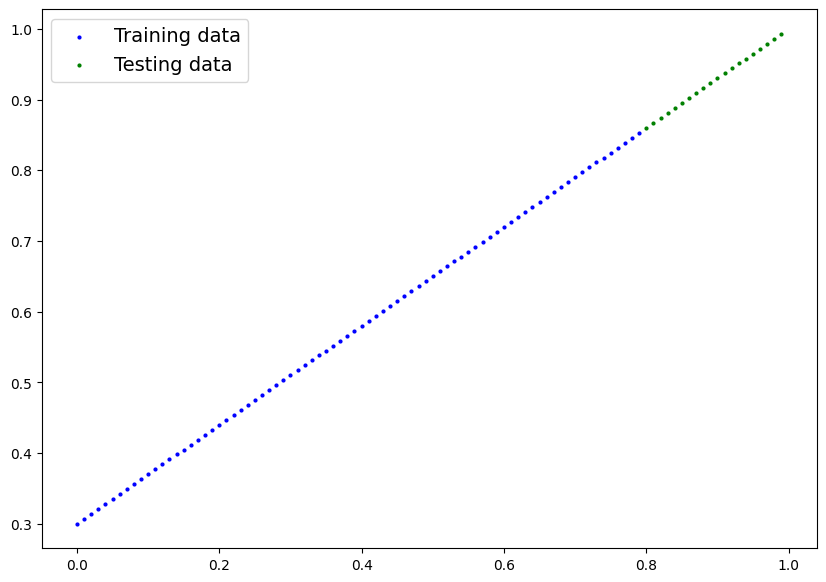

In [48]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=None)

In [50]:
CircleModelV1()

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit a straight line

In [51]:
# Same architecture as model_1 (but using nn.Sequential())

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [58]:
# Loss and optimizer
loss_fn_regression = nn.L1Loss()
optimizer_regression = torch.optim.SGD(params=model_2.parameters(),
                                       lr=0.01)

In [59]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training Loop
for epoch in range(epochs):
  model_2.train()

  # Forward Pass
  y_pred_regression = model_2(X_train_regression)

  # Calculate the loss
  loss = loss_fn_regression(y_pred_regression, y_train_regression)

  # Optimizer zero grad
  optimizer_regression.zero_grad()

  # Backpropogation
  loss.backward()

  optimizer_regression.step()

  ## Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred_regression = model_2(X_test_regression)
    test_loss = loss_fn_regression(test_pred_regression, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.05325 | Test Loss: 0.02637
Epoch: 100 | Train Loss: 0.00673 | Test Loss: 0.00292
Epoch: 200 | Train Loss: 0.00653 | Test Loss: 0.00142
Epoch: 300 | Train Loss: 0.00651 | Test Loss: 0.00129
Epoch: 400 | Train Loss: 0.00649 | Test Loss: 0.00132
Epoch: 500 | Train Loss: 0.00677 | Test Loss: 0.00134
Epoch: 600 | Train Loss: 0.00675 | Test Loss: 0.00135
Epoch: 700 | Train Loss: 0.00674 | Test Loss: 0.00135
Epoch: 800 | Train Loss: 0.00672 | Test Loss: 0.00135
Epoch: 900 | Train Loss: 0.00670 | Test Loss: 0.00134


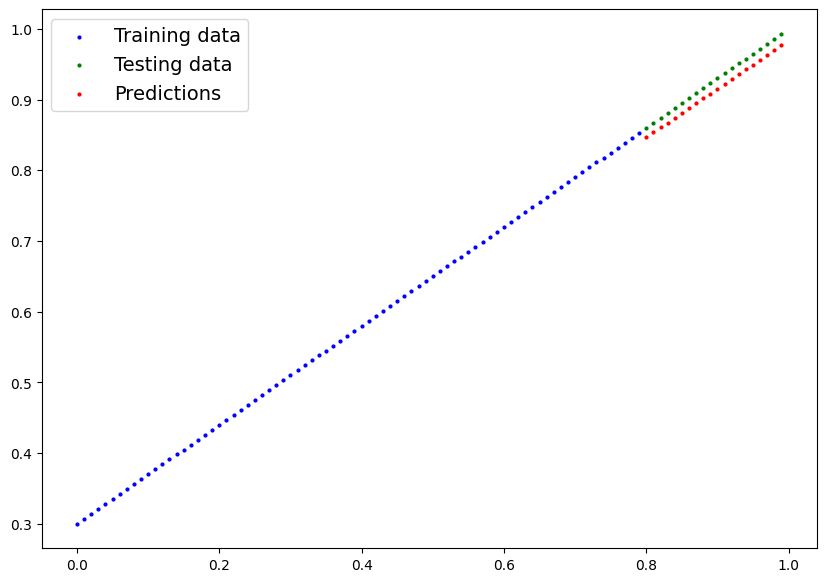

In [60]:
with torch.inference_mode():
  y_preds_regression = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds_regression)

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions

### 6.1 Recreating non-linear data (red and blue circles)

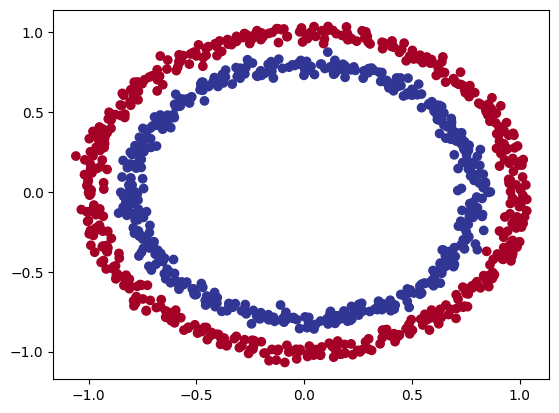

In [65]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [66]:
# Convert data to tensors and then to train and tes splits
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear - straight lines
* Non-linear - non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patters in data.

In [87]:
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [88]:
model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [89]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.5)

In [90]:
# Set epochs
epochs = 1000

for epoch in range(epochs):
  model_3.train()

  # Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate the test loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.70683 | Train Acc: 50.00% | Test Loss: 0.70118 | Test Acc: 50.00%
Epoch: 100 | Train Loss: 0.68649 | Train Acc: 52.62% | Test Loss: 0.68518 | Test Acc: 55.50%
Epoch: 200 | Train Loss: 0.65059 | Train Acc: 67.00% | Test Loss: 0.65948 | Test Acc: 59.00%
Epoch: 300 | Train Loss: 0.56396 | Train Acc: 57.12% | Test Loss: 0.56989 | Test Acc: 55.00%
Epoch: 400 | Train Loss: 0.47211 | Train Acc: 70.12% | Test Loss: 0.51512 | Test Acc: 64.00%
Epoch: 500 | Train Loss: 0.41380 | Train Acc: 78.38% | Test Loss: 0.51446 | Test Acc: 67.50%
Epoch: 600 | Train Loss: 0.07675 | Train Acc: 99.88% | Test Loss: 0.10817 | Test Acc: 99.50%
Epoch: 700 | Train Loss: 0.02354 | Train Acc: 100.00% | Test Loss: 0.04185 | Test Acc: 100.00%
Epoch: 800 | Train Loss: 0.01415 | Train Acc: 100.00% | Test Loss: 0.02869 | Test Acc: 100.00%
Epoch: 900 | Train Loss: 0.01025 | Train Acc: 100.00% | Test Loss: 0.02269 | Test Acc: 100.00%


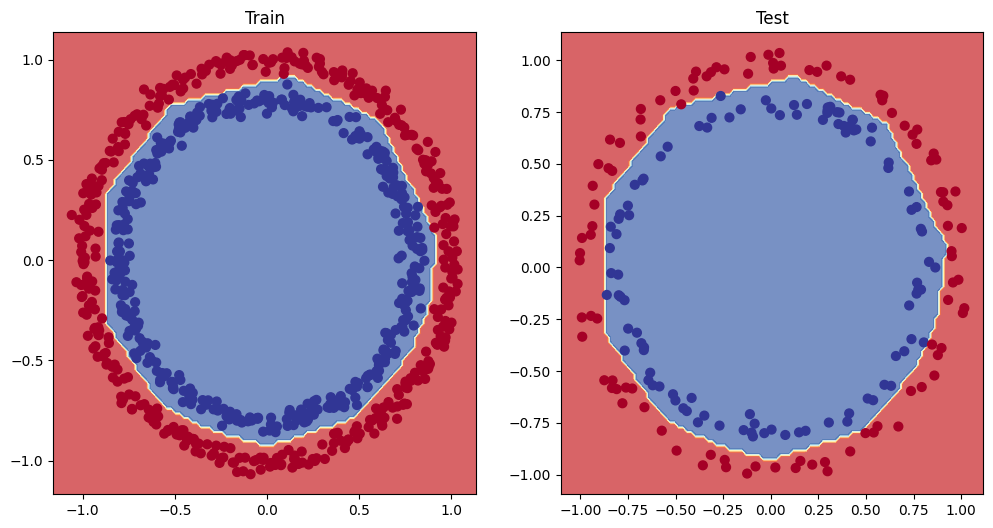

In [97]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)
plt.show()

### 6.4 Evaluating a model trained with non-linear activation functions

In [93]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## 7. Replicating non-linear activation functions

Neural Networks, rather than us telling the model what to learn, we give it the tools to dicover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions

In [100]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

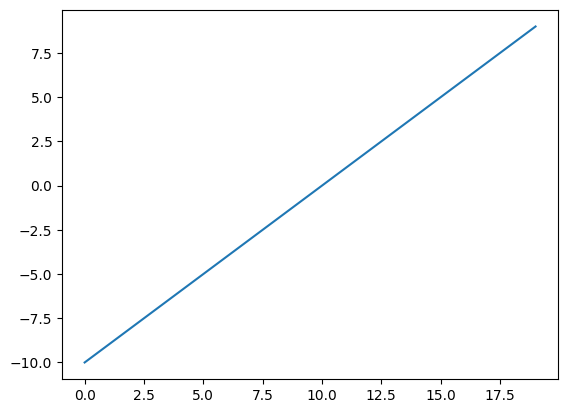

In [104]:
# Visualize the tensor
plt.plot(A)
plt.show()

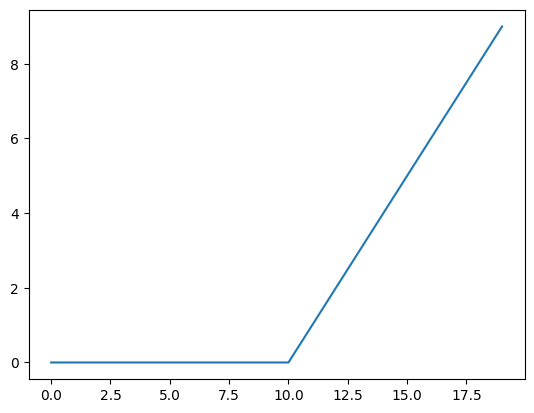

In [103]:
plt.plot(torch.relu(A))
plt.show()

In [105]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # inputs must be tensors
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

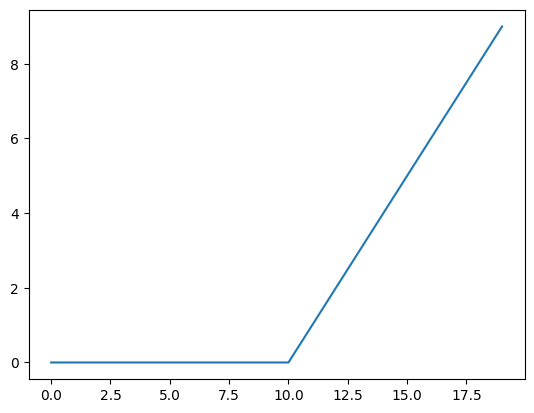

In [106]:
plt.plot(relu(A))
plt.show()

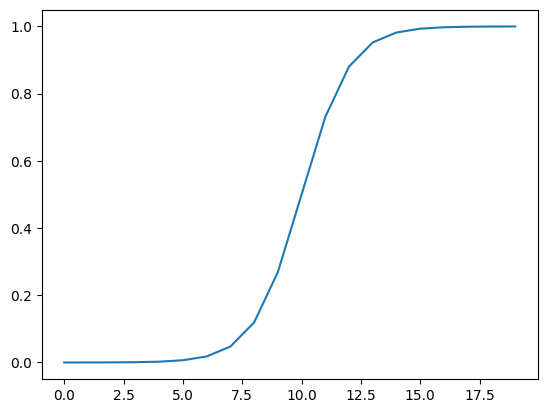

In [108]:
plt.plot(torch.sigmoid(A))
plt.show()

In [109]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/(1 + torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

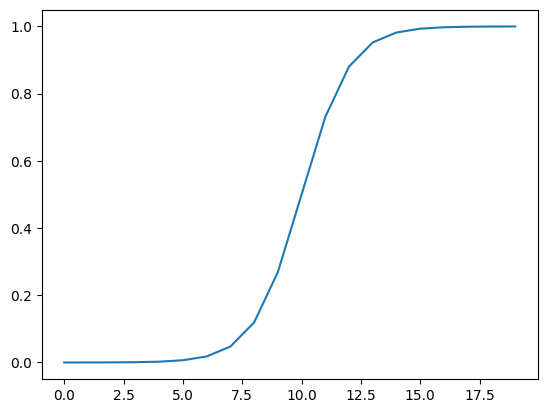

In [110]:
plt.plot(sigmoid(A))
plt.show()

## 8. Putting it all together with a multi-class classification problem

* Binary Classification = one thing or the other (spam or not spam, cat vs dog etc)
* Multi-class classification (cat vs dog vs cows etc..)

### 8.1 Creating a toy multi-class dataset

In [ ]:
import requests
from pathlib import Path

# download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

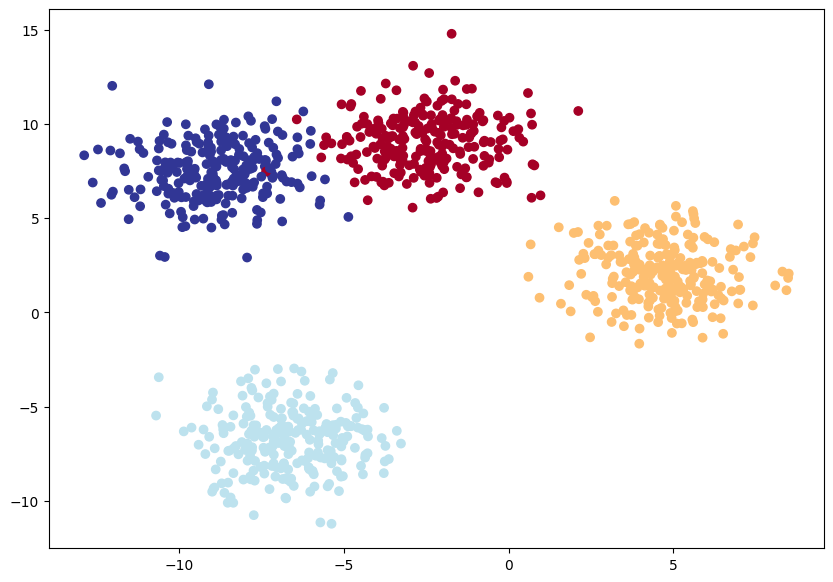

In [3]:
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from helper_functions import accuracy_fn, plot_decision_boundary

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Turn Data into Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# Split data into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# Visualize
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

### 8.2 Building a multi-class classification model

In [4]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Send the data to the right device
X_blob_train, y__blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model.
      output_features (int): Number of output features of the model (Number of output classes)
      hidden_units (int, optional): Number of hidden units between the layers, Defaults to 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification models

In [5]:
# Create a loss function for Multi-Class Classification model
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's utputs (logits) to prediction probabilities and then to prediction labels

In [6]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test).squeeze()
y_logits[:10]

tensor([[-0.4454,  0.6166, -0.5921, -0.0181],
        [ 0.6280,  0.2286, -0.3678, -0.0083],
        [ 1.9158, -0.4806,  0.2280,  1.0744],
        [-0.0142,  0.4016, -0.4228,  0.2457],
        [-0.5122,  0.7214, -0.7142, -0.3731],
        [ 0.7123,  0.2092, -0.3650, -0.0561],
        [ 1.7980, -0.4446,  0.2122,  1.1025],
        [-0.1891,  0.5790, -0.6123, -0.2575],
        [ 2.1863, -0.5820,  0.2895,  1.0931],
        [-0.2927,  0.6229, -0.6427, -0.2870]], device='cuda:0')

In [7]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [8]:
y_pred_probs = torch.softmax(y_logits, dim=1)

In [9]:
y_pred_probs[:10]

tensor([[0.1590, 0.4599, 0.1373, 0.2438],
        [0.3892, 0.2610, 0.1438, 0.2060],
        [0.5858, 0.0533, 0.1083, 0.2525],
        [0.2234, 0.3385, 0.1485, 0.2897],
        [0.1563, 0.5365, 0.1277, 0.1796],
        [0.4151, 0.2510, 0.1414, 0.1925],
        [0.5525, 0.0587, 0.1132, 0.2756],
        [0.2108, 0.4543, 0.1380, 0.1968],
        [0.6460, 0.0405, 0.0969, 0.2165],
        [0.1920, 0.4796, 0.1353, 0.1931]], device='cuda:0')

In [10]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0')

In [11]:
torch.max(y_pred_probs[0])

tensor(0.4599, device='cuda:0')

In [12]:
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred[:10], y_blob_test[:10]

(tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

In [13]:
y_pred.shape, y_blob_test.shape

(torch.Size([200]), torch.Size([200]))

In [14]:
### 8.5 Create a training and testing loop for a multi-class PyTorch model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):
  ### Training
  model_4.train()

  # Forward pass
  y_logits = model_4(X_blob_train)
  y_pred_prob = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_pred_prob, dim=1)

  # Calculate the loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test).squeeze()
    test_pred_prob = torch.softmax(test_logits, dim=1)
    test_pred = torch.argmax(test_pred_prob, dim=1)

    test_loss = loss_fn(test_logits,
                        y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Train Accuracy: {acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 1.5725 | Train Accuracy: 24.88 | Test Loss: 0.7069 | Test Acc: 70.00
Epoch: 10 | Train Loss: 0.1988 | Train Accuracy: 99.00 | Test Loss: 0.1796 | Test Acc: 99.00
Epoch: 20 | Train Loss: 0.0988 | Train Accuracy: 99.00 | Test Loss: 0.0899 | Test Acc: 99.50
Epoch: 30 | Train Loss: 0.0683 | Train Accuracy: 99.00 | Test Loss: 0.0606 | Test Acc: 99.50
Epoch: 40 | Train Loss: 0.0546 | Train Accuracy: 99.12 | Test Loss: 0.0469 | Test Acc: 99.50
Epoch: 50 | Train Loss: 0.0470 | Train Accuracy: 99.12 | Test Loss: 0.0391 | Test Acc: 99.50
Epoch: 60 | Train Loss: 0.0422 | Train Accuracy: 99.12 | Test Loss: 0.0342 | Test Acc: 99.50
Epoch: 70 | Train Loss: 0.0390 | Train Accuracy: 99.12 | Test Loss: 0.0308 | Test Acc: 99.50
Epoch: 80 | Train Loss: 0.0367 | Train Accuracy: 99.12 | Test Loss: 0.0283 | Test Acc: 99.50
Epoch: 90 | Train Loss: 0.0350 | Train Accuracy: 99.12 | Test Loss: 0.0264 | Test Acc: 99.50


In [15]:
y_logits.shape

torch.Size([800, 4])

In [16]:
y_blob_train.shape

torch.Size([800])

In [17]:
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

### 8.6 Making and evaluatinfg predictions with a PyToch multi-class model

In [18]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[  6.9014,  12.2021, -11.2931,  -6.1444],
        [  3.8197, -11.0353,   1.4841,   9.4514],
        [-11.0080, -16.0514,  17.3073,   8.6052],
        [  2.9629,   8.4148,  -6.0406,  -4.6246],
        [ 10.7763,   6.0826, -12.2515,  -0.6433],
        [  4.0822, -13.8948,   2.4645,  11.5614],
        [-10.9732, -12.8784,  15.9188,   6.3608],
        [  8.6778,   1.4938,  -8.3539,   1.9933],
        [-11.9541, -21.5600,  20.5352,  12.2381],
        [  9.2717,   3.1270,  -9.6000,   1.0094]], device='cuda:0')

In [19]:
# Go from logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[4.9633e-03, 9.9504e-01, 6.2231e-11, 1.0717e-08],
        [3.5686e-03, 1.2619e-09, 3.4527e-04, 9.9609e-01],
        [5.0438e-13, 3.2540e-15, 9.9983e-01, 1.6621e-04],
        [4.2697e-03, 9.9573e-01, 5.2511e-07, 2.1636e-06],
        [9.9092e-01, 9.0697e-03, 9.8901e-11, 1.0879e-05],
        [5.6433e-04, 8.7951e-12, 1.1194e-04, 9.9932e-01],
        [2.0938e-12, 3.1155e-13, 9.9993e-01, 7.0634e-05],
        [9.9800e-01, 7.5709e-04, 4.0026e-08, 1.2476e-03],
        [7.7616e-15, 5.2263e-19, 9.9975e-01, 2.4919e-04],
        [9.9760e-01, 2.1398e-03, 6.3550e-09, 2.5745e-04]], device='cuda:0')

In [20]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [21]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

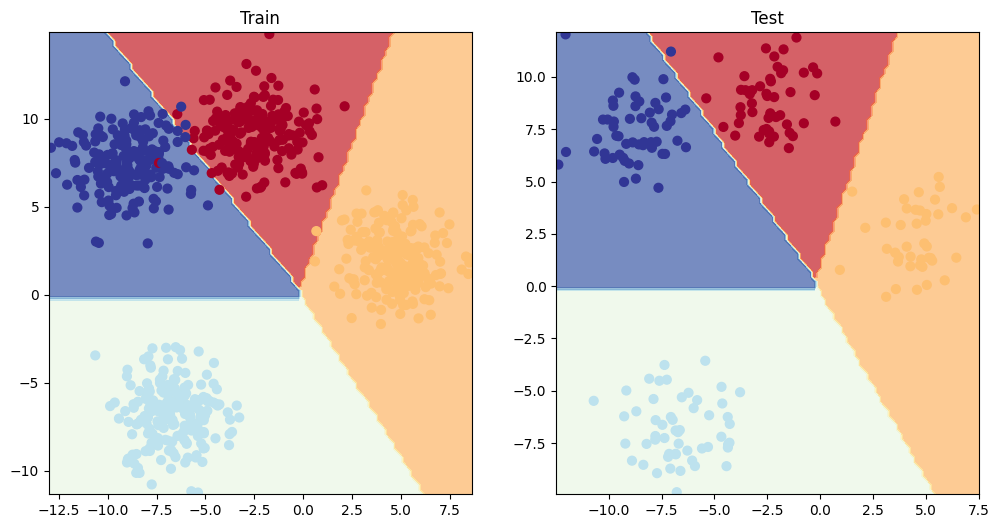

In [23]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
plt.show()

## 9. A few more classification metrics.. (to evaluate our classifications model)

* Accuracy - Out of 100 samples, how many does our model get right
* Precision
* Recall
* F1-score
* Confusion Matrix
* Classification Report



In [29]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.5 MB/s eta 0:00:00


In [38]:
from torcheval.metrics import MulticlassAccuracy

# Instantiate the class
Accuracy = MulticlassAccuracy().to(device)

# Update with true values and predicted values
Accuracy.update(y_blob_test, y_preds)

# Calculate Accuracy
Accuracy.compute()

tensor(0.9950, device='cuda:0')

In [39]:
from torcheval.metrics import MulticlassPrecision, MulticlassRecall, MulticlassF1Score

# Instantiate the classes
precision = MulticlassPrecision(num_classes=4).to(device)
recall = MulticlassRecall(num_classes=4).to(device)
f1_score = MulticlassF1Score(num_classes=4).to(device)

# Update with predicted and true values
precision.update(y_blob_test, y_preds)
recall.update(y_blob_test, y_preds)
f1_score.update(y_blob_test, y_preds)

# Calculate the metrics
print(f"Precision: {precision.compute()}")
print(f"Recall: {recall.compute()}")
print(f"F1-Score: {f1_score.compute()}")

Precision: 0.9950000047683716
Recall: 0.9950000047683716
F1-Score: 0.9950000047683716
